# Max Independent Set

## Introduction

In the Maximum Independent Set Problem [[1](#MISWiki)], we need to find the largest subset of vertices in a given graph, such that no two vertices in the subset are adjacent. This is an NP-Hard problem in general graph structures, with applications in various fields such as network deign, bioinformatics, and scheduling.

## Mathematical Formulation
Given a graph $G=(V,E)$, an independent set $I \subseteq V$ is a set of vertices such that no two vertices in $I$ are adjacent. The Maximum Independent Set Problem is the problem of finding the independent set $I$ with maximum cardinality. In binary form, we can represent each vertex $v$ being in or out of the independent set $I$ by a binary variable $x_v$, with $x_v = 1$ if $v \in I$, and $x_v = 0$ otherwise. The problem can then be formulated as:

Maximize $\sum_{v \in V} x_v$

Subject to:

$x_{u} + x_{v} \leq 1, \forall (u, v) \in E$

where each $x_v \in {0,1}$.


# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
import networkx as nx
import numpy as np
import pyomo.core as pyo
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
def mis(graph: nx.Graph) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)

    @model.Constraint(graph.edges)
    def independent_rule(model, node1, node2):
        return model.x[node1] + model.x[node2] <= 1

    model.cost = pyo.Objective(expr=sum(model.x.values()), sense=pyo.maximize)

    return model

The model consists of:

- Index set declarations (model.Nodes, model.Arcs).
- Binary variable declaration for each node (model.x) indicating whether that node is chosen to be included in the set.
- Constraint rule - for each edge we require at least one of the corresponding node variables to be 0.
- Objective rule – the sum of the variables equals to the set size.

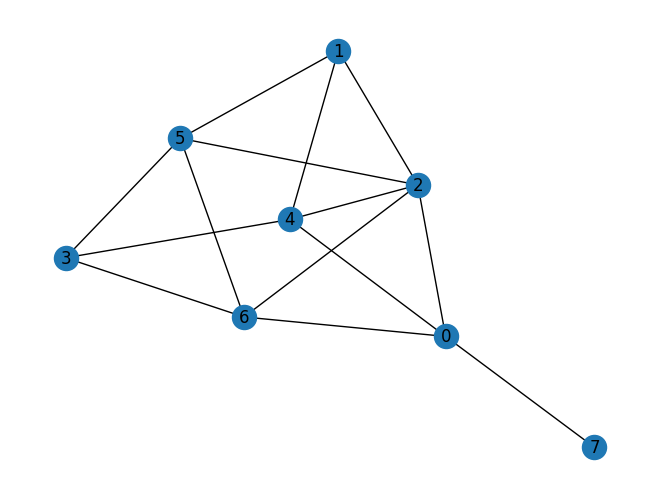

In [3]:
num_nodes = 8
p_edge = 0.4
graph = nx.fast_gnp_random_graph(n=num_nodes, p=p_edge, seed=12345)

nx.draw_kamada_kawai(graph, with_labels=True)
mis_model = mis(graph)

In [4]:
mis_model.pprint()

2 Set Declarations
    independent_rule_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :   14 : {(0, 2), (0, 4), (0, 6), (0, 7), (1, 2), (1, 4), (1, 5), (2, 4), (2, 5), (2, 6), (3, 4), (3, 5), (3, 6), (5, 6)}
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    8 : {0, 1, 2, 3, 4, 5, 6, 7}

1 Var Declarations
    x : Size=8, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 : 

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the `CombinatorialProblem` quantum object. Under the hood it tranlates the pyomo model to a quantum model of the qaoa algorithm, with cost hamiltonian translated from the pyomo model. We can choose the number of layers for the qaoa ansatz using the argument `num_layers`, and the `penalty_factor`, which will be the coefficient of the constraints term in the cost hamiltonian.

In [8]:
from classiq import *
from classiq.applications.combinatorial_optimization import CombinatorialProblem

combi = CombinatorialProblem(pyo_model=mis_model, num_layers=3, penalty_factor=10)

qmod = combi.get_model()

In [9]:
write_qmod(qmod, "max_independent_set")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
qprog = combi.get_qprog()
show(qprog)

Opening: https://nightly.platform.classiq.io/circuit/5f349e4d-590e-4d1b-ac4e-d63aaec23f47?version=0.61.0.dev3


We also set the quantum backend we want to execute on:

In [11]:
from classiq.execution import *

execution_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator"),
)

We now solve the problem by calling the `optimize` method of the `CombinatorialProblem` object. For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`maxiter`) and the $\alpha$-parameter (`quantile`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [12]:
%%time
cost_values = []
optimized_params = combi.optimize(
    execution_preferences, maxiter=60, cost_trace=cost_values, quantile=0.7
)

CPU times: user 4.71 s, sys: 159 ms, total: 4.87 s
Wall time: 1min 32s


We can check the convergence of the run:

Text(0.5, 1.0, 'Cost convergence')

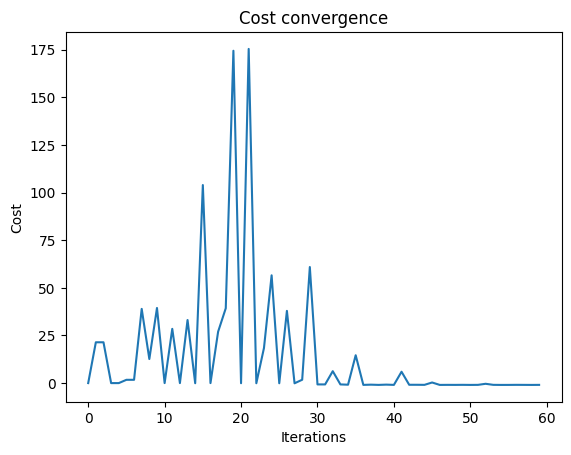

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(cost_values)
axes.set_xlabel("Iterations")
axes.set_ylabel("Cost")
axes.set_title("Cost convergence")

# Optimization Results

We can also examine the statistics of the algorithm. The optimization is always defined as a minimzation problem, so the positive maximization objective was tranlated to a negative minimization one by the pyomo to qmod translator.

In order to get samples with the optimized parameters, we call the `get_results` method:

In [14]:
optimization_result = combi.get_results()
optimization_result.sort_values(by="cost").head(5)

,solution,probability,cost
47,"{'x_0': 1, 'x_1': 1, 'x_2': 0, 'x_3': 1, 'x_4'...",0.002930,-3.0
59,"{'x_0': 0, 'x_1': 1, 'x_2': 0, 'x_3': 0, 'x_4'...",0.001953,-3.0
95,"{'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_3': 0, 'x_4'...",0.000977,-3.0
64,"{'x_0': 0, 'x_1': 0, 'x_2': 1, 'x_3': 1, 'x_4'...",0.001465,-3.0
88,"{'x_0': 0, 'x_1': 0, 'x_2': 0, 'x_3': 0, 'x_4'...",0.000977,-3.0


And the histogram:

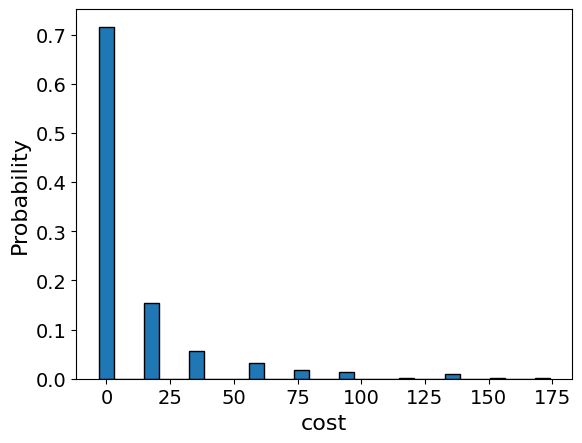

In [22]:
optimization_result["cost"].plot(
    kind="hist", bins=30, edgecolor="black", weights=optimization_result["probability"]
)
plt.ylabel("Probability", fontsize=16)
plt.xlabel("cost", fontsize=16)
plt.tick_params(axis="both", labelsize=14)

Let us plot the solution:

In [16]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]
best_solution

{'x_0': 1,
 'x_1': 1,
 'x_2': 0,
 'x_3': 1,
 'x_4': 0,
 'x_5': 0,
 'x_6': 0,
 'x_7': 0}

In [17]:
independent_set = [node for node in graph.nodes if best_solution[f"x_{node}"] == 1]
print("Independent Set: ", independent_set)
print("Size of Independent Set: ", len(independent_set))

Independent Set:  [0, 1, 3]
Size of Independent Set:  3


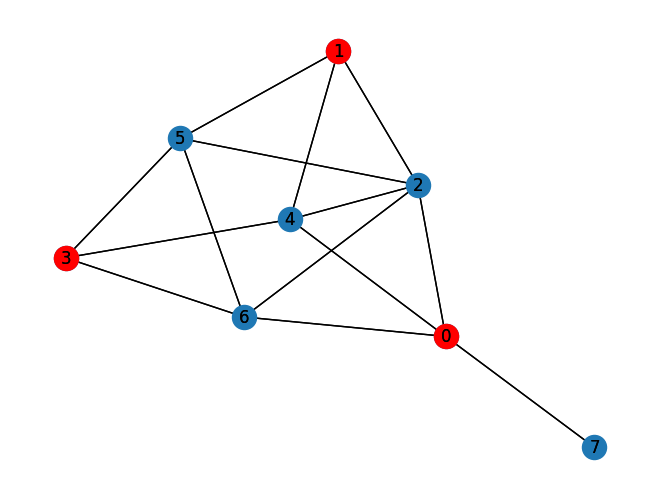

In [18]:
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=independent_set,
    node_color="r",
)

## Comparison to a classical solver

Lastly, we can compare to the classical solution of the problem:

In [19]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(mis_model)
classical_solution = [pyo.value(mis_model.x[i]) for i in graph.nodes]

In [20]:
independent_set_classical = [
    node for node in graph.nodes if np.allclose(classical_solution[node], 1)
]
print("Classical Independent Set: ", independent_set_classical)
print("Size of Classical Independent Set: ", len(independent_set_classical))

Classical Independent Set:  [0, 1, 3]
Size of Classical Independent Set:  3


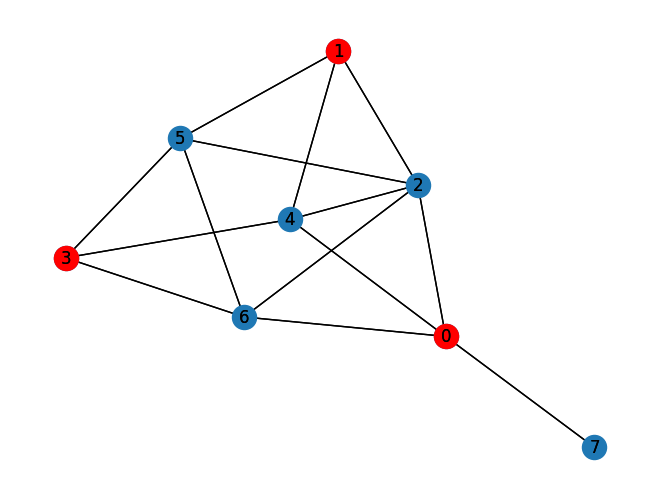

In [21]:
nx.draw_kamada_kawai(graph, with_labels=True)
nx.draw_kamada_kawai(
    graph,
    with_labels=True,
    nodelist=independent_set_classical,
    node_color="r",
)


## References

<a id='MISWiki'>[1]</a>: [Max Independent Set (Wikipedia)](https://en.wikipedia.org/wiki/Partition_problem)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
